In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()
# nodes = {"pi"+str(i+2):i for i in range(4)}
nodes = ["pi2", "pi3", "pi4", "pi5"]

In [4]:
sampled_data = {}
m=200
for experiment in range(1,4):
    node_data, models, inliers = get_node_data(data, experiment, return_models=True)
    for i in range(4):
        node_data[i] = node_data[i].sample(200).reset_index(drop=True)
    sampled_data[experiment] = {"data" : node_data, "models" : models, "inliers" : inliers}

## Visualising Data

In [5]:
from visualising import visualise_experiments
# visualise_experiments(data)

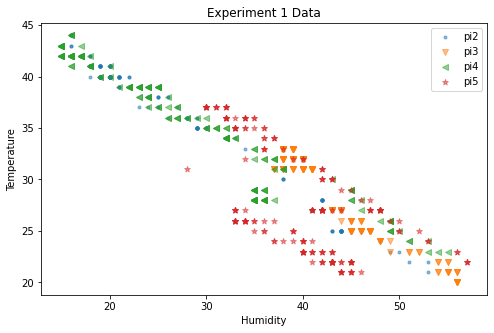

In [6]:
from visualising import visualise_experiment
visualise_experiment(sampled_data[1]["data"])

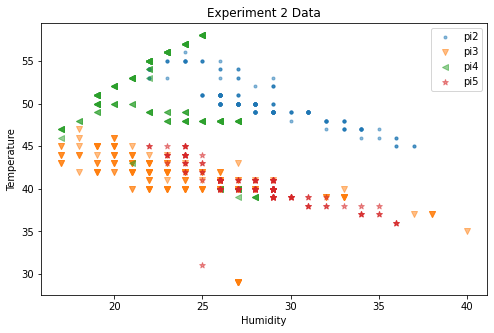

In [7]:
visualise_experiment(sampled_data[2]["data"])

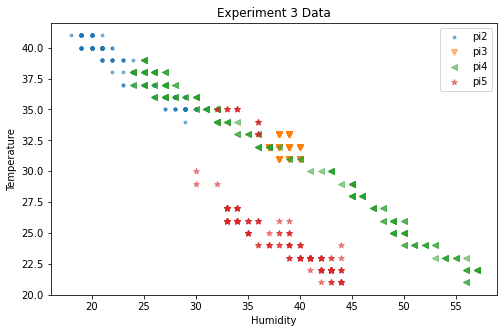

In [8]:
visualise_experiment(sampled_data[3]["data"])

## Similarity MMD

In [9]:
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_nodes, other_nodes, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_nodes, other_nodes, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [10]:
from maximum_mean_discrepancy import get_tensor_samples
m = 200
samples = get_tensor_samples(sampled_data[1], sample_size=m)

In [11]:
similar_nodes = ["pi2","pi4"]
other_nodes = ["pi3","pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+-------------+
|     Nodes      | Similar MMD |
+----------------+-------------+
| ('pi2', 'pi4') |  2.40234375 |
+----------------+-------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 35.80540466308594  |
| ('pi3', 'pi4') | 29.409774780273438 |
| ('pi5', 'pi2') | 26.482131958007812 |
| ('pi5', 'pi4') | 21.084854125976562 |
| ('pi3', 'pi5') | 3.916717529296875  |
+----------------+--------------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | 7.2069091796875 |
+----------------+-----------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi3', 'pi2') | 107.41619873046875 |
| ('pi3', 'pi4') | 88.22930908203125  |
| ('pi5', 'pi2') | 79.44635009765625  |
| ('pi5', 'pi4') | 63.25433349609375  |


similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [12]:
tensor_samples = get_tensor_samples(sampled_data[3], sample_size=m)

In [13]:
similar_nodes = ["pi2", "pi4"]
other_nodes = ["pi3", "pi5"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+--------------------+
|     Nodes      |    Similar MMD     |
+----------------+--------------------+
| ('pi2', 'pi4') | 29.335830688476562 |
| ('pi3', 'pi2') | 28.388015747070312 |
| ('pi3', 'pi4') |   2.572021484375   |
| ('pi5', 'pi4') |  5.48016357421875  |
| ('pi3', 'pi5') | 6.563934326171875  |
+----------------+--------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi5', 'pi2') | 39.38813781738281 |
+----------------+-------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi2', 'pi4') |     88.0078125    |
| ('pi3', 'pi2') |     85.1640625    |
| ('pi3', 'pi4') |   7.716064453125  |
| ('pi5', 'pi4') | 16.44049072265625 |
| ('pi3', 'pi5') | 19.69183349609375 |
+----------------+-------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+---

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

### Experiment 2

In [14]:
tensor_samples = get_tensor_samples(sampled_data[2], sample_size=m)

In [15]:
similar_nodes = ["pi3", "pi5"]
other_nodes = ["pi2", "pi4"]
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(tensor_samples, similar_nodes, other_nodes, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 5.264678955078125 |
+----------------+-------------------+
+----------------+--------------------+
|     Nodes      |   Dissimilar MMD   |
+----------------+--------------------+
| ('pi2', 'pi3') | 9.437042236328125  |
| ('pi2', 'pi5') | 9.621673583984375  |
| ('pi4', 'pi3') | 9.940399169921875  |
| ('pi4', 'pi5') | 16.465057373046875 |
| ('pi2', 'pi4') |  6.55999755859375  |
+----------------+--------------------+

+----------------+-------------------+
|     Nodes      |    Similar MMD    |
+----------------+-------------------+
| ('pi3', 'pi5') | 15.79388427734375 |
+----------------+-------------------+
+----------------+-------------------+
|     Nodes      |   Dissimilar MMD  |
+----------------+-------------------+
| ('pi2', 'pi3') | 28.31121826171875 |
| ('pi2', 'pi5') |  28.864990234375  |
| ('pi4', 'pi3') |   29.8212890625   |
| ('pi

## Testing Hypothesis

In [9]:
from sklearn.preprocessing import StandardScaler
from visualising import visualise_train_test_data

def get_xy_data(data):
    x = data.humidity.values.astype(np.float32)
    y = data.temperature.values.astype(np.float32)
    return x, y

def get_model_data(node_data, standardised = False):
    model_data = {}
    
    if standardised:
        scaler = StandardScaler()
        scaler.fit(pd.concat(node_data))
    
    for i in range(4):
        node = "pi"+str(i+2)
        if standardised:
            std_node = scaler.transform(node_data[i])
            model_data[node] = (std_node[:,0],std_node[:,1])
        else:
            model_data[node] = get_xy_data(node_data[i])
        
    return model_data

In [10]:
from modelling import fit_clf, score_clf
from prettytable import PrettyTable

def test_in_pairs(similar_pairs, model_data, models):
    t = PrettyTable(['Model Node', 'Test Node', 'Discrepancy'])
    for pair in similar_pairs:
        x = model_data[pair[0]]
        y = model_data[pair[1]]
        
        model_x = models[pair[0]]
        ex = fit_clf(model_x, x)
        exy = score_clf(model_x, y)

        model_y = models[pair[1]]
        ey = fit_clf(model_y, y)
        eyx = score_clf(model_y, x)       
        
        t.add_row([pair[1], pair[0], abs(ex-eyx)])  
        t.add_row([pair[0], pair[1], abs(ey-exy)])
    print(t)

In [44]:
from maximum_mean_discrepancy import get_tensor_samples, get_similar_pairs_mmd
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable
from node import get_similar_other_nodes_sets, get_similar_pairs_ocsvm, remove_outliers
from modelling import grid_search_models
from itertools import combinations as comb

def get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth):
    node_data = sampled_data[experiment]["data"]
    
    tensor_samples = get_tensor_samples(node_data, sample_size=200)
    similar_nodes, other_nodes = get_similar_other_nodes_sets(experiment)
    asmmd = ASDMMD(tensor_samples, similar_nodes, other_nodes, kernel, kernel_bandwidth, return_tables = False)
    print(f"The average MMD between similar sets is {asmmd}")
    
    similar_pairs, similar_nodes = get_similar_pairs_mmd(node_data, asmmd, kernel, kernel_bandwidth)
    print(f"The following pairs of nodes were deemed similar {similar_pairs} using the MMD method.\n")
    
    return similar_pairs, similar_nodes

def get_ocsvm_similar_pairs(threshold, unidirectional = False):
    node_data, models, inliers = sampled_data[experiment].values()
    similar_pairs, similar_nodes = get_similar_pairs_ocsvm(node_data, models, inliers, threshold, unidirectional)
    print(f"The following pairs of nodes were deemed similar {similar_pairs} using the OCSVM method.\n")
    
    return similar_pairs, similar_nodes

def select_model_data(node_data, similar_nodes, standardised):
    model_data = get_model_data(node_data, standardised)
    selected_model_data = {node : model_data[node] for node in similar_nodes}
    return selected_model_data

def get_data(experiment, method, similar_pairs_args, standardised):
    node_data = sampled_data[experiment]["data"]
    if method in ["mmd", "ocsvm"]:
        if method == "mmd":
            kernel, kernel_bandwidth = similar_pairs_args
            similar_pairs, similar_nodes = get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth)
            node_data = sampled_data[experiment]
        elif method == "ocsvm":
            threshold, unidirectional = similar_pairs_args
            similar_pairs, similar_nodes = get_ocsvm_similar_pairs(threshold, unidirectional)
                                            
        model_data = select_model_data(node_data, similar_nodes, standardised)
        
    elif method in ["both", "verify", "trio"]:
        threshold, unidirectional = similar_pairs_args[1]
        ocsvm_similar_pairs, ocsvm_similar_nodes = get_ocsvm_similar_pairs(threshold, unidirectional)

        kernel, kernel_bandwidth = similar_pairs_args[0]
        mmd_similar_pairs, mmd_similar_nodes = get_mmd_similar_pairs(experiment, kernel, kernel_bandwidth)
        
        if method in ["both", "trio"]:
            similar_pairs = [mmd_similar_pairs, ocsvm_similar_pairs]
            similar_nodes = [mmd_similar_nodes, ocsvm_similar_nodes]
            
            mmd_model_data = select_model_data(node_data, mmd_similar_nodes, standardised)
            ocsvm_model_data = select_model_data(node_data, ocsvm_similar_nodes, standardised)
            
            model_data = [mmd_model_data, ocsvm_model_data]
        
        if method in  ["verify", "trio"]:
            str_mmd_similar_pairs = str([pair[::-1] for pair in mmd_similar_pairs]) + str(mmd_similar_pairs)
            verify_similar_pairs = [pair for pair in ocsvm_similar_pairs if str(pair) in str_mmd_similar_pairs]
            verify_similar_nodes = [node for node in ocsvm_similar_nodes if node in str(verify_similar_pairs)]
            
            verify_model_data = select_model_data(node_data, verify_similar_nodes, standardised)

            if method == "trio":
                similar_pairs.append(verify_similar_pairs)
                similar_nodes.append(verify_similar_nodes)
                model_data.append(verify_model_data)
            else:
                similar_pairs = verify_similar_pairs
                similar_nodes = verify_similar_nodes
                model_data = verify_model_data

    return model_data, similar_pairs, similar_nodes

def test_hypothesis(clf_name, model_data, similar_pairs, similar_nodes): 
    print("Optimising Models... \n")
    models = grid_search_models(clf_name, model_data, similar_nodes)
    test_in_pairs(similar_pairs, model_data, models)
    print()
    
def test_hypothesis_all_clfs(model_data, similar_pairs, similar_nodes):        
    test_hypothesis("svr", model_data, similar_pairs, similar_nodes)
    test_hypothesis("lsvr", model_data, similar_pairs, similar_nodes)
    test_hypothesis("lreg", model_data, similar_pairs, similar_nodes)

def test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes):
    print("MMD Method \n")
    test_hypothesis_all_clfs(model_data[0], similar_pairs[0], similar_nodes[0])    
    print("OCSVM Method \n")
    test_hypothesis_all_clfs(model_data[1], similar_pairs[1], similar_nodes[1])
    if len(model_data[2]) != 0:
        print("MMD OCSVM Verify Method \n")
        test_hypothesis_all_clfs(model_data[2], similar_pairs[2], similar_nodes[2])

In [45]:
model_data, similar_pairs, similar_nodes = get_data(1, "trio", similar_pairs_args = [("linear", 0.5), (0.3, False)], 
                                                   standardised=False)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi3', 'pi4'), ('pi3', 'pi5')] using the OCSVM method.

The average MMD between similar sets is 10.2630615234375
The following pairs of nodes were deemed similar [('pi2', 'pi4')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+--------------------+-------------------------+--------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model     | Optimised Model R  |
+------+----------------+--------------------+-------------------------+--------------------+
| pi2  |     SVR()      | 0.9814344934093634 | SVR(C=100, epsilon=0.5) | 0.9900908032249742 |
| pi4  |     SVR()      | 0.9532451563591029 |  SVR(C=100, epsilon=1)  | 0.9644871638190621 |
+------+----------------+--------------------+-------------------------+--------------------+
+------------+-----------+---------------------+
| Model Node | Test Node |     Discrepancy     |
+------------+-----------+---------------------+


In [50]:
model_data, similar_pairs, similar_nodes = get_data(2, "trio", similar_pairs_args = [("linear", 0.7), (0.3, False)], 
                                                   standardised=False)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi3', 'pi4'), ('pi3', 'pi5')] using the OCSVM method.

The average MMD between similar sets is 29.8402099609375
The following pairs of nodes were deemed similar [('pi3', 'pi5')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+--------------------+-------------------------+---------------------+
| Node | Baseline Model |     Baseline R     |     Optimised Model     |  Optimised Model R  |
+------+----------------+--------------------+-------------------------+---------------------+
| pi3  |     SVR()      | 0.3554632515537065 |  SVR(C=100, epsilon=1)  | 0.42995090562718163 |
| pi5  |     SVR()      | 0.699916871501354  | SVR(C=100, epsilon=0.2) |  0.7165372880169886 |
+------+----------------+--------------------+-------------------------+---------------------+
+------------+-----------+---------------------+
| Model Node | Test Node |     Discrepancy     |
+------------+-----------+-----------------

In [53]:
model_data, similar_pairs, similar_nodes = get_data(3, "trio", similar_pairs_args = [("linear", 0.5), (0.3, False)], 
                                                   standardised=False)
test_hypothesis_all_methods_clfs(model_data, similar_pairs, similar_nodes)

The following pairs of nodes were deemed similar [('pi3', 'pi4'), ('pi3', 'pi5')] using the OCSVM method.

The average MMD between similar sets is 25.46331787109375
The following pairs of nodes were deemed similar [('pi3', 'pi4')] using the MMD method.

MMD Method 

Optimising Models... 

+------+----------------+---------------------+--------------------------+---------------------+
| Node | Baseline Model |      Baseline R     |     Optimised Model      |  Optimised Model R  |
+------+----------------+---------------------+--------------------------+---------------------+
| pi3  |     SVR()      | 0.07371558473243478 | SVR(C=0.1, epsilon=0.2)  | 0.11307121361881989 |
| pi4  |     SVR()      |  0.9871991094025578 | SVR(C=100, epsilon=0.01) |  0.9889631946705175 |
+------+----------------+---------------------+--------------------------+---------------------+
+------------+-----------+--------------------+
| Model Node | Test Node |    Discrepancy     |
+------------+-----------+------

+------------+-----------+-------------------+
| Model Node | Test Node |    Discrepancy    |
+------------+-----------+-------------------+
|    pi4     |    pi3    | 2.016221929670754 |
|    pi3     |    pi4    | 0.545104935899925 |
+------------+-----------+-------------------+

Optimising Models... 

+------+--------------------+----------------------+----------------------------------+----------------------+
| Node |   Baseline Model   |      Baseline R      |         Optimised Model          |  Optimised Model R   |
+------+--------------------+----------------------+----------------------------------+----------------------+
| pi3  | LinearRegression() | 0.030865256919448525 |        LinearRegression()        | 0.030865256919448525 |
| pi4  | LinearRegression() |  0.9858186524625332  | LinearRegression(normalize=True) |  0.9858186525082833  |
+------+--------------------+----------------------+----------------------------------+----------------------+
+------------+-----------+--